In [1]:
#importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re

In [2]:
#loading bengluru house dataset
house_df=pd.read_csv("Bengaluru_House_Data.csv")
print("======House details=======")
print(house_df.head())

======House details=======
              area_type   availability                  location       size  \
0  Super built-up  Area         19-Dec  Electronic City Phase II      2 BHK   
1            Plot  Area  Ready To Move          Chikka Tirupathi  4 Bedroom   
2        Built-up  Area  Ready To Move               Uttarahalli      3 BHK   
3  Super built-up  Area  Ready To Move        Lingadheeranahalli      3 BHK   
4  Super built-up  Area  Ready To Move                  Kothanur      2 BHK   

   society total_sqft  bath  balcony   price  
0  Coomee        1056   2.0      1.0   39.07  
1  Theanmp       2600   5.0      3.0  120.00  
2      NaN       1440   2.0      3.0   62.00  
3  Soiewre       1521   3.0      1.0   95.00  
4      NaN       1200   2.0      1.0   51.00  


In [3]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import time
# Clean location names
house_df['location'] = house_df['location'].str.strip().str.lower()

# Unique locations
unique_locations = house_df['location'].unique()
print(f"Total unique locations: {len(unique_locations)}")

# Setup geocoder
geolocator = Nominatim(user_agent="bengaluru_price_prediction")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

location_coords = {}

for i, loc in enumerate(unique_locations, 1):
    try:
        query = f"{loc}, bengaluru, india"
        location = geocode(query)

        if location:
            location_coords[loc] = (location.latitude, location.longitude)
            print(f"[{i}/{len(unique_locations)}]  {loc} -> {location.latitude}, {location.longitude}")
        else:
            location_coords[loc] = (None, None)
            print(f"[{i}/{len(unique_locations)}] {loc} -> Not found")

    except Exception as e:
        location_coords[loc] = (None, None)
        print(f"[{i}/{len(unique_locations)}]{loc} -> Error: {e}")

    # Save checkpoint every 100 requests
    if i % 100 == 0:
        temp_df = pd.DataFrame.from_dict(location_coords, orient='index',
                                         columns=['latitude','longitude']).reset_index()
        temp_df.rename(columns={'index':'location'}, inplace=True)
        temp_df.to_csv("location_checkpoint.csv", index=False)
        print(f" Saved checkpoint at {i} locations")

    time.sleep(1)  # avoid overloading the server

# Final save
location_df = pd.DataFrame.from_dict(location_coords, orient='index',
                                     columns=['latitude','longitude']).reset_index()
location_df.rename(columns={'index':'location'}, inplace=True)

merged_df = house_df.merge(location_df, on='location', how='left')

print("Missing coords after geocoding:", merged_df['latitude'].isna().sum())
merged_df.to_csv("Bengaluru_House_Data_With_Coordinates.csv", index=False)
print(" Done! Saved final dataset as Bengaluru_House_Data_With_Coordinates.csv")


Total unique locations: 1284
[1/1284]  electronic city phase ii -> 12.8463512, 77.6690975
[2/1284]  chikka tirupathi -> 12.8957681, 77.8671014
[3/1284]  uttarahalli -> 12.9055682, 77.5455438


KeyboardInterrupt: 

In [2]:
merged_df=pd.read_csv("Bengaluru_House_Data_With_Coordinates.csv")
#handling missing values
merged_df=merged_df.dropna(subset=['location','size','balcony','bath'])
nan_society=merged_df[merged_df['society'].isna()].index
half_index_len=len(nan_society)//2
merged_df.loc[nan_society[:half_index_len], 'society'] = 'Prestige Shantiniketan'
merged_df.loc[nan_society[half_index_len:], 'society'] = 'Sobha Dream Acres'
merged_df=merged_df.dropna(subset=['latitude','longitude'])


In [3]:
print(merged_df.isnull().sum())

area_type       0
availability    0
location        0
size            0
society         0
total_sqft      0
bath            0
balcony         0
price           0
latitude        0
longitude       0
dtype: int64


In [4]:
merged_df.shape

(11363, 11)

In [5]:
#standarizing
print(merged_df.dtypes)
merged_df[['bath','balcony']]=merged_df[['bath','balcony']].astype(int)

def convert_sqft(x):
    try:
        return float(x)
    except:
        if 'Sq. Meter' in x:
            value = float(x.replace('Sq. Meter', '').strip())
            return value * 10.7639
        else:
            return None  

merged_df['total_sqft'] = merged_df['total_sqft'].apply(convert_sqft)
print(f"=====after changes====")
print(merged_df.dtypes)


area_type        object
availability     object
location         object
size             object
society          object
total_sqft       object
bath            float64
balcony         float64
price           float64
latitude        float64
longitude       float64
dtype: object
=====after changes====
area_type        object
availability     object
location         object
size             object
society          object
total_sqft      float64
bath              int64
balcony           int64
price           float64
latitude        float64
longitude       float64
dtype: object


In [6]:
merged_df.rename(columns={'size':'BHK'},inplace=True)
merged_df['BHK'].str.replace('Bedroom','BHK')

0        2 BHK
1        4 BHK
2        3 BHK
3        3 BHK
4        2 BHK
         ...  
13314    3 BHK
13315    5 BHK
13317    2 BHK
13318    4 BHK
13319    1 BHK
Name: BHK, Length: 11363, dtype: object

In [7]:
#adding a column of price_per_sqft
merged_df['price_per_sqft'] = (merged_df['price'] * 100000) / merged_df['total_sqft']
print(merged_df['price_per_sqft'])

0         3699.810606
1         4615.384615
2         4305.555556
3         6245.890861
4         4250.000000
             ...     
13314     6530.612245
13315     6689.834926
13317     5258.545136
13318    10407.336319
13319     3090.909091
Name: price_per_sqft, Length: 11363, dtype: float64


In [8]:
#handling outliers in price_per_sqft
Q1=merged_df['price_per_sqft'].quantile(0.25)
Q3=merged_df['price_per_sqft'].quantile(0.75)
IQR=Q3-Q1
print(f"Q1={Q1}\nQ3={Q3}\nIQR={IQR}")


Q1=4243.791399069034
Q3=7150.085816371271
IQR=2906.294417302237


In [9]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

merged_df = merged_df[(merged_df['price_per_sqft'] >= lower_bound) & 
                    (merged_df['price_per_sqft'] <= upper_bound)]

In [10]:
print(merged_df.head())
merged_df.shape

              area_type   availability                  location        BHK  \
0  Super built-up  Area         19-Dec  electronic city phase ii      2 BHK   
1            Plot  Area  Ready To Move          chikka tirupathi  4 Bedroom   
2        Built-up  Area  Ready To Move               uttarahalli      3 BHK   
3  Super built-up  Area  Ready To Move        lingadheeranahalli      3 BHK   
4  Super built-up  Area  Ready To Move                  kothanur      2 BHK   

                  society  total_sqft  bath  balcony   price   latitude  \
0                 Coomee       1056.0     2        1   39.07  12.846351   
1                 Theanmp      2600.0     5        3  120.00  12.895768   
2  Prestige Shantiniketan      1440.0     2        3   62.00  12.905568   
3                 Soiewre      1521.0     3        1   95.00  13.002669   
4  Prestige Shantiniketan      1200.0     2        1   51.00  13.061360   

   longitude  price_per_sqft  
0  77.669098     3699.810606  
1  77.867101

(10159, 12)

In [11]:
#adding a column of dist_to_centre
from geopy.distance import geodesic

city_center = (12.9763, 77.6033)  # MG Road area

merged_df['dist_to_center_km'] = merged_df.apply(
    lambda row: geodesic((row['latitude'], row['longitude']), city_center).km, axis=1
)
print(merged_df.columns)

Index(['area_type', 'availability', 'location', 'BHK', 'society', 'total_sqft',
       'bath', 'balcony', 'price', 'latitude', 'longitude', 'price_per_sqft',
       'dist_to_center_km'],
      dtype='object')


In [12]:
def extract_bhk(size_str):
    if isinstance(size_str, str):
        match = re.search(r'\d+', size_str) 
        if match:
            return float(match.group())
    return None  
merged_df['BHK'] = merged_df['BHK'].apply(extract_bhk)
print(merged_df['BHK'])

0        2.0
1        4.0
2        3.0
3        3.0
4        2.0
        ... 
13314    3.0
13315    5.0
13317    2.0
13318    4.0
13319    1.0
Name: BHK, Length: 10159, dtype: float64


In [13]:
#encoding location feature
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
merged_df['location_encoded']=le.fit_transform(merged_df['location'])

In [14]:
#spliting the data set
from sklearn.model_selection import train_test_split
features=['total_sqft','BHK','bath','dist_to_center_km','price_per_sqft','location_encoded']
X=merged_df[features]
y=merged_df['price']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [15]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

model = LGBMRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
print("R²:", r2_score(y_test, y_pred))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1014
[LightGBM] [Info] Number of data points in the train set: 8127, number of used features: 6
[LightGBM] [Info] Start training from score 84.140054
RMSE: 10.783362184581406
R²: 0.973205771083988


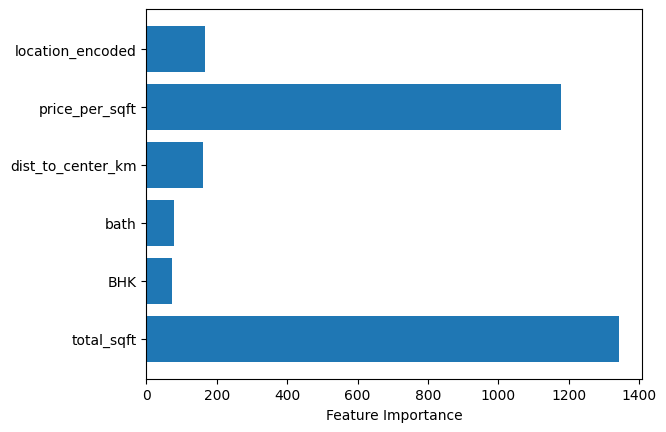

In [16]:
importance = model.feature_importances_
plt.barh(features, importance)
plt.xlabel("Feature Importance")
plt.show()

      Actual Price  Predicted Price
4758         29.00        29.156028
7931         68.50        70.165154
4023         86.00        86.946544
2895         53.56        53.886632
4059         70.00        70.226230
6639         45.00        45.346549
6657        120.00       120.921047
320          83.09        82.029361
4779         59.76        60.089137
7955        125.00       128.769215


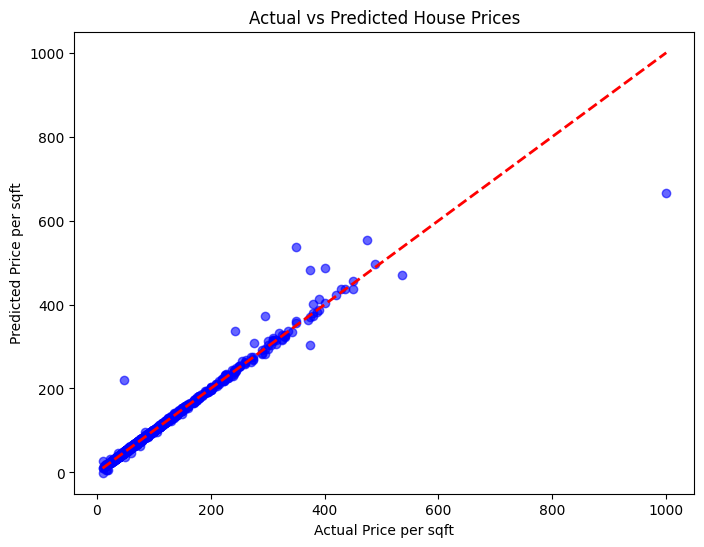

In [20]:
y_pred = model.predict(X_test)

# Creating a DataFrame to compare actual vs predicted
comparison_df = pd.DataFrame({
    'Actual Price': y_test,
    'Predicted Price': y_pred
})

print(comparison_df.head(10))

# Scatter plot to visualize actual vs predicted
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  
plt.xlabel('Actual Price per sqft')
plt.ylabel('Predicted Price per sqft')
plt.title('Actual vs Predicted House Prices')
plt.legend
plt.show()


In [17]:
merged_df.to_csv("Cleaned_Bengluru_housing_data_with_location.csv",index=False)